# Tweets francophones : comparaison **TF‑IDF** vs **Skip‑gram**

Ce notebook adapte la comparaison des embeddings au contexte **tweets FR** (francophones).

- **TF‑IDF** (avec stopwords français, bigrammes)
- **Skip‑gram** (Word2Vec `sg=1`, moyenne des vecteurs de mots par tweet)

Évaluations :
1. **Extrinsèque** : classification de sentiments (labels `pos`, `neg`)
2. **Intrinsèque** : similarités, voisins, **PCA** et **t‑SNE**




# Les Principes du Machine Learning

## Qu'est-ce que le Machine Learning ?

Le **Machine Learning** (apprentissage automatique) est une branche de l'intelligence artificielle qui permet aux ordinateurs d'apprendre et de s'améliorer automatiquement à partir de l'expérience, sans être explicitement programmés pour chaque tâche spécifique.

## Principe Fondamental

Le principe central du machine learning repose sur l'idée que les machines peuvent **identifier des motifs** (patterns) dans les données et utiliser ces motifs pour faire des **prédictions** ou prendre des **décisions** sur de nouvelles données jamais vues auparavant.


## Les Trois Types Principaux

### 1. **Apprentissage Supervisé**
- Utilise des données étiquetées (input + output connu)
- L'algorithme apprend à mapper les entrées vers les sorties correctes
- **Exemples** : Classification d'emails (spam/non-spam), prédiction de prix

### 2. **Apprentissage Non Supervisé**
- Travaille avec des données non étiquetées
- L'algorithme découvre des structures cachées dans les données
- **Exemples** : Clustering de clients, réduction de dimensionnalité

### 3. **Apprentissage par Renforcement**
- L'agent apprend par interaction avec son environnement
- Reçoit des récompenses ou pénalités selon ses actions
- **Exemples** : Jeux vidéo, robots autonomes

## Processus Général

1. **Collecte des données** : Rassembler un dataset représentatif
2. **Préparation des données** : Nettoyage, transformation, normalisation
3. **Choix du modèle** : Sélection de l'algorithme approprié
4. **Entraînement** : Le modèle apprend sur les données d'entraînement
5. **Évaluation** : Test des performances sur des données de validation
6. **Déploiement** : Utilisation du modèle sur de nouvelles données

## Applications en NLP

Dans le contexte de ce notebook, nous appliquons ces principes au **Traitement du Langage Naturel** :
- **Vectorisation** : Transformer le texte en nombres (TF-IDF, Word Embeddings)
- **Apprentissage de représentations** : Skip-gram pour capturer la sémantique des mots
- **Classification** : Prédire le sentiment ou la catégorie d'un texte

---

#  Modèles de Classification et Métriques d'Évaluation

## Qu'est-ce qu'un Modèle de Classification ?

Un **modèle de classification** est un algorithme d'apprentissage automatique supervisé qui apprend à assigner des **étiquettes de classe** (ou catégories) à des données d'entrée basées sur des exemples d'entraînement étiquetés. 

### Principe de fonctionnement :
1. **Entraînement** : Le modèle apprend des patterns à partir d'un ensemble de données étiquetées
2. **Prédiction** : Il applique ces patterns pour prédire les classes de nouvelles données non vues
3. **Types courants** : Régression logistique, SVM, Random Forest, réseaux de neurones, etc.

### Exemples d'applications :
- Détection de spam dans les emails
- Reconnaissance d'images (chat vs chien)
- Analyse de sentiment (positif vs négatif)
- Diagnostic médical automatisé

## Métriques d'Évaluation pour la Classification

### 1. **Accuracy (Exactitude)**
- **Formule** : (Prédictions correctes) / (Total des prédictions)
- **Interprétation** : Pourcentage global de bonnes classifications
- **Limite** : Peut être trompeuse avec des classes déséquilibrées

### 2. **Precision (Précision)**
- **Formule** : Vrais Positifs / (Vrais Positifs + Faux Positifs)
- **Question** : "Parmi les éléments prédits comme positifs, combien le sont vraiment ?"
- **Utile quand** : Le coût des faux positifs est élevé

### 3. **Recall (Rappel/Sensibilité)**
- **Formule** : Vrais Positifs / (Vrais Positifs + Faux Négatifs)
- **Question** : "Parmi tous les éléments positifs réels, combien avons-nous détectés ?"
- **Utile quand** : Le coût des faux négatifs est élevé

### 4. **F1-Score**
- **Formule** : 2 × (Precision × Recall) / (Precision + Recall)
- **Avantage** : Moyenne harmonique équilibrant précision et rappel
- **F1-Score Macro** : Moyenne des F1-scores de chaque classe

### 5. **Matrice de Confusion**
Tableau 2×2 (pour classification binaire) montrant :
- **Vrais Positifs (TP)** : Correctement classés comme positifs
- **Vrais Négatifs (TN)** : Correctement classés comme négatifs  
- **Faux Positifs (FP)** : Incorrectement classés comme positifs
- **Faux Négatifs (FN)** : Incorrectement classés comme négatifs

### 6. **Autres Métriques Importantes**
- **Spécificité** : TN / (TN + FP) - Capacité à identifier les négatifs
- **AUC-ROC** : Aire sous la courbe ROC - Performance globale du modèle
- **Support** : Nombre d'échantillons réels de chaque classe

## Choix des Métriques selon le Contexte

- **Données équilibrées** → Accuracy suffit souvent
- **Classes déséquilibrées** → F1-Score, Precision/Recall plus informatifs
- **Coût asymétrique d'erreurs** → Optimiser selon la métrique critique
- **Vue d'ensemble** → Combiner plusieurs métriques + matrice de confusion

In [ ]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

try:
    import gensim
    from gensim.models import Word2Vec
    HAS_GENSIM = True
except Exception:
    HAS_GENSIM = False
    print("[INFO] gensim non disponible : Skip‑gram sera désactivé.")

sns.set(style="whitegrid")


## Configuration
Chemin vers le CSV et hyperparamètres (adaptés aux tweets FR).

In [2]:

DATASET_PATH = "data/french_tweets.csv"  # ⚙️ Remplacer par votre chemin
TEST_SIZE = 0.2
RANDOM_STATE = 42

# TF-IDF
MAX_FEATURES = 30000
NGRAM_RANGE = (1, 2)  # unigrams + bigrams

# Skip-gram (Word2Vec)
EMBED_DIM = 200
WINDOW = 4
MIN_WORD_COUNT = 2
EPOCHS = 10 # paramètres deep learning


## Prétraitement (tweets FR)
Nettoyage et tokenisation adaptés : URLs, mentions, hashtags, emojis, ponctuation, accents.
- Conservation des **hashtags** sous forme de token `hashtag_<mot>`
- Mentions normalisées en `@user`
- Remplacement d'emojis courants par tokens `emojipos` / `emojineg`
- Stopwords français pour TF‑IDF


In [4]:
import unicodedata

URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
MENTION_RE = re.compile(r"@[A-Za-z0-9_]+")
HASHTAG_FALLBACK_RE = re.compile(r"#([A-Za-zÀ-ÖØ-öø-ÿ0-9_]+)")

EMOJI_POS = set(["😀","😃","😄","😊","😍","👍","🔥","💯","😁","🙂","❤️","🥰","🎉"])
EMOJI_NEG = set(["😞","😠","😡","😢","😭","👎","💔","🤮","🙁","☹️","😩","😤"])

PUNCT_RE = re.compile(r"['`´'""«»()\[\]{}.,;:!?…\-–—]")
def normalize_text_fr(s: str) -> str:
    s = s.strip()
    s = URL_RE.sub(" ", s)
    # Mentions -> @user
    s = MENTION_RE.sub(" @user ", s)
    # Hashtags -> hashtag_mot
    def repl_hashtag(m):
        word = m.group(1)
        return f" hashtag_{word.lower()} "
    s = HASHTAG_FALLBACK_RE.sub(repl_hashtag, s)
    # Remplacer emojis par tokens
    s = "".join([" emojipos " if ch in EMOJI_POS else (" emojineg " if ch in EMOJI_NEG else ch) for ch in s])
    # Normaliser accents
    s = unicodedata.normalize('NFKC', s)
    # Retirer ponctuation (sauf @user et hashtag_)
    s = PUNCT_RE.sub(" ", s)
    # Lowercase
    s = s.lower()
    # Compact spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_fr(s: str):
    s = normalize_text_fr(s)
    # Split basique sur espaces
    toks = s.split()
    return toks

## Chargement des données
Le CSV doit contenir `text` et `label`.

In [5]:

if not os.path.isfile(DATASET_PATH):
    raise FileNotFoundError(f"Fichier introuvable : {DATASET_PATH} Mettez à jour DATASET_PATH.")

DF = pd.read_csv(DATASET_PATH)
assert {'text','label'}.issubset(DF.columns), "Le CSV doit contenir les colonnes 'text' et 'label'."
DF = DF.dropna(subset=['text','label']).reset_index(drop=True)
# la distribution des labels en pourcentage

print("Distribution des labels:", DF['label'].value_counts(normalize=True) * 100)
DF.head()

Distribution des labels: label
0    50.539849
1    49.460151
Name: proportion, dtype: float64


,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [6]:
DF['text'][356]

"J'étais juste à l'écoute des bonbons pour la première fois à jamais! Je leur manque tellement, pouvons-nous aller à chi town pour les visites plz?"

## Split entraînement / test (stratifié)

In [7]:

X_text = DF['text'].astype(str).values
y = DF['label'].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Train={len(X_train_text)} | Test={len(X_test_text)}")


Train=1221379 | Test=305345


## Embeddings **TF‑IDF** (stopwords FR, n‑grammes)

In [ ]:

vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, stop_words=['french'])
# entrainement du tf-idf
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)
print(X_train_tfidf.shape, X_test_tfidf.shape)


(1221379, 30000) (305345, 30000)


## Embeddings **Skip‑gram** (Word2Vec sg=1)
Tokens issus du prétraitement. Embedding du tweet = moyenne des vecteurs de mots.

In [14]:
X_train_tokens = [tokenize_fr(t) for t in X_train_text]
X_test_tokens  = [tokenize_fr(t) for t in X_test_text]

In [18]:
len(X_train_tokens)

1221379

In [19]:
if HAS_GENSIM:
    print("[Skip‑gram] Entraînement Word2Vec...")
    w2v_model = Word2Vec(
        sentences=X_train_tokens,
        vector_size=EMBED_DIM,
        window=WINDOW,
        min_count=MIN_WORD_COUNT,
        sg=1,
        workers=1,
        epochs=EPOCHS,
        seed=RANDOM_STATE,
    )
else:
    w2v_model = None
    print("[WARN] Skip‑gram non disponible (gensim absent).")

import numpy as np

def doc_embed_avg(tokens, model=None, dim=EMBED_DIM):
    if model is None:
        return np.zeros(dim, dtype=np.float32)
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if len(vecs) == 0:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

X_train_skip = np.vstack([doc_embed_avg(t, w2v_model, EMBED_DIM) for t in X_train_tokens])
X_test_skip  = np.vstack([doc_embed_avg(t, w2v_model, EMBED_DIM) for t in X_test_tokens])
print(X_train_skip.shape, X_test_skip.shape)


[Skip‑gram] Entraînement Word2Vec...
(1221379, 200) (305345, 200)


# Évaluation extrinsèque : classification de sentiments (tweets FR)

In [20]:

results = []

# Modèle : Logistic Regression
# Initialisation et entrainement du modèle
clf_tfidf = LogisticRegression(max_iter=500, n_jobs=2)
print('Régression logistique [TF-IDF]  Entraînement...')
clf_tfidf.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='macro')
results.append({"type":"TF-IDF","accuracy":acc_tfidf,"f1_macro":f1_tfidf})
print(f"[TF‑IDF] Acc={acc_tfidf:.4f} | F1(macro)={f1_tfidf:.4f}")

if w2v_model is not None:
    # Initialisation et entrainement du modèle
    clf_skip = LogisticRegression(max_iter=500, n_jobs=-1)
    print('Régression logistique [Skip-gram]  Entraînement...')
    clf_skip.fit(X_train_skip, y_train)

    # Prédictions et évaluations
    y_pred_skip = clf_skip.predict(X_test_skip)
    acc_skip = accuracy_score(y_test, y_pred_skip)
    f1_skip = f1_score(y_test, y_pred_skip, average='macro')
    results.append({"type":"Skip-gram","accuracy":acc_skip,"f1_macro":f1_skip})
    print(f"[Skip‑gram] Acc={acc_skip:.4f} | F1(macro)={f1_skip:.4f}")
else:
    print("[Skip‑gram] non évalué.")

pd.DataFrame(results)


Régression logistique [TF-IDF]  Entraînement...


c:\Users\mbial\OneDrive\Bureau\LinkedIn posts\50 jours du NLP traditionnel à l'IA gen\yt_video_comments_analysis\coursnlp\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=2', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


[TF‑IDF] Acc=0.8037 | F1(macro)=0.8037
Régression logistique [Skip-gram]  Entraînement...


c:\Users\mbial\OneDrive\Bureau\LinkedIn posts\50 jours du NLP traditionnel à l'IA gen\yt_video_comments_analysis\coursnlp\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


[Skip‑gram] Acc=0.7608 | F1(macro)=0.7607


,type,accuracy,f1_macro
0,TF-IDF,0.803701,0.803701
1,Skip-gram,0.760795,0.760713


[Skip‑gram] Rapport:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77    154321
           1       0.76      0.75      0.76    151024

    accuracy                           0.76    305345
   macro avg       0.76      0.76      0.76    305345
weighted avg       0.76      0.76      0.76    305345

              precision    recall  f1-score   support

           0       0.76      0.77      0.77    154321
           1       0.76      0.75      0.76    151024

    accuracy                           0.76    305345
   macro avg       0.76      0.76      0.76    305345
weighted avg       0.76      0.76      0.76    305345



[Skip‑gram] Rapport:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77    154321
           1       0.76      0.75      0.76    151024

    accuracy                           0.76    305345
   macro avg       0.76      0.76      0.76    305345
weighted avg       0.76      0.76      0.76    305345

              precision    recall  f1-score   support

           0       0.76      0.77      0.77    154321
           1       0.76      0.75      0.76    151024

    accuracy                           0.76    305345
   macro avg       0.76      0.76      0.76    305345
weighted avg       0.76      0.76      0.76    305345



/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_471/2241792987.py:10: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


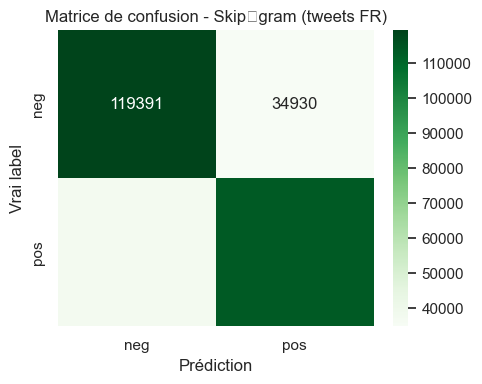

In [24]:
if w2v_model is not None:
    print("[Skip‑gram] Rapport:")
    print(classification_report(y_test, y_pred_skip))
    cm_skip = confusion_matrix(y_test, y_pred_skip)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_skip, annot=True, fmt='d', cmap='Greens', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
    plt.title('Matrice de confusion - Skip‑gram (tweets FR)')
    plt.xlabel('Prédiction')
    plt.ylabel('Vrai label')
    plt.tight_layout()
    plt.show()

[TF‑IDF] Rapport:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80    154321
           1       0.80      0.81      0.80    151024

    accuracy                           0.80    305345
   macro avg       0.80      0.80      0.80    305345
weighted avg       0.80      0.80      0.80    305345

              precision    recall  f1-score   support

           0       0.81      0.80      0.80    154321
           1       0.80      0.81      0.80    151024

    accuracy                           0.80    305345
   macro avg       0.80      0.80      0.80    305345
weighted avg       0.80      0.80      0.80    305345



[TF‑IDF] Rapport:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80    154321
           1       0.80      0.81      0.80    151024

    accuracy                           0.80    305345
   macro avg       0.80      0.80      0.80    305345
weighted avg       0.80      0.80      0.80    305345

              precision    recall  f1-score   support

           0       0.81      0.80      0.80    154321
           1       0.80      0.81      0.80    151024

    accuracy                           0.80    305345
   macro avg       0.80      0.80      0.80    305345
weighted avg       0.80      0.80      0.80    305345



/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_471/3804749237.py:11: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


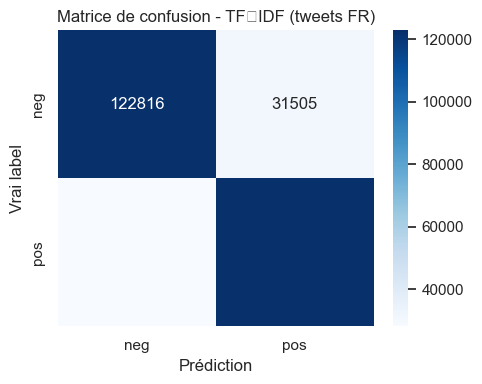

In [25]:

# Rapports + matrices de confusion
print("[TF‑IDF] Rapport:")
print(classification_report(y_test, y_pred_tfidf))
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.title('Matrice de confusion - TF‑IDF (tweets FR)')
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.tight_layout()
plt.show()




# Évaluation intrinsèque : similarités et visualisations (PCA / t‑SNE)

In [27]:

# Choisir un tweet de test
idx = 0
q_text = X_test_text[idx]
print("Tweet requête:", q_text)

# Voisins par similarité cosinus (TF‑IDF)
sim_tfidf = cosine_similarity(X_test_tfidf[idx], X_train_tfidf).ravel()
order_tfidf = np.argsort(-sim_tfidf)[:10]
print("Top 5 voisins TF-IDF:")
for j in order_tfidf[:5]:
    print(f"[sim={sim_tfidf[j]:.3f}] {X_train_text[j][:140]}...")

# Voisins pour Skip‑gram
if w2v_model is not None:
    sim_skip = cosine_similarity([X_test_skip[idx]], X_train_skip).ravel()
    order_skip = np.argsort(-sim_skip)[:10]
    print("Top‑5 voisins Skip‑gram:")
    for j in order_skip[:5]:
        print(f"[sim={sim_skip[j]:.3f}] {X_train_text[j][:140]}...")
else:
    print("Skip‑gram indisponible pour voisins.")


Tweet requête: Donc, si vous avez aimé, vous pouvez visiter ou acheter leur nouvel album sur iTunes pour seulement .99! fais le
Top 5 voisins TF-IDF:
[sim=0.428] Vous l'avez aimé!...
[sim=0.428] & Vous avez aimé?...
[sim=0.412] Si vous avez aimé, voici plus...
[sim=0.385] Donc vous avez aimé mes terrains?...
[sim=0.372] Nouvel album...
Top 5 voisins TF-IDF:
[sim=0.428] Vous l'avez aimé!...
[sim=0.428] & Vous avez aimé?...
[sim=0.412] Si vous avez aimé, voici plus...
[sim=0.385] Donc vous avez aimé mes terrains?...
[sim=0.372] Nouvel album...
Top‑5 voisins Skip‑gram:
[sim=0.928] Pouvez-vous me faire savoir si votre album est disponible sur iTunes? hehe merci!...
[sim=0.926] Pouvez-vous envoyer un courrier électronique mp3 proche de vous? Comme un retard, j'ai acheté le cd dans le magasin et la chanson n'est pas ...
[sim=0.921] Mec, vous devez aller sur www.natehighfield.com et télécharger la moitié de l'album gratuitement, je sais que vous l'aimerez!...
[sim=0.916] Si vous allez l'achet

## PCA (2D) des tweets

In [28]:

# PCA pour TF‑IDF
# Initialisation du PCA
pca_tfidf = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_tfidf_dense = X_test_tfidf.toarray()
# Entrainement
X_tfidf_2d = pca_tfidf.fit_transform(X_test_tfidf_dense)

plt.figure(figsize=(6,5))
for lab in np.unique(y_test):
    mask = (y_test == lab)
    plt.scatter(X_tfidf_2d[mask,0], X_tfidf_2d[mask,1], label=str(lab), s=20)
plt.title('PCA (2D) - TF‑IDF (tweets FR)')
plt.legend(title='Label', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# PCA pour Skip‑gram
if w2v_model is not None:
    pca_skip = PCA(n_components=2, random_state=RANDOM_STATE)
    X_skip_2d = pca_skip.fit_transform(X_test_skip)
    plt.figure(figsize=(6,5))
    for lab in np.unique(y_test):
        mask = (y_test == lab)
        plt.scatter(X_skip_2d[mask,0], X_skip_2d[mask,1], label=str(lab), s=20)
    plt.title('PCA (2D) - Skip‑gram (tweets FR)')
    plt.legend(title='Label', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()


: 

# Comparaison consolidée

In [ ]:

res_df = pd.DataFrame(results)
print(res_df)

for metric in ["accuracy","f1_macro"]:
    plt.figure(figsize=(6,4))
    sns.barplot(x="type", y=metric, data=res_df)
    plt.title(f"Comparaison {metric} (tweets FR)")
    plt.ylim(0,1.0)
    plt.tight_layout()
    plt.show()


## Exercice : interpréter les résultats et faites vos conclusions